# 1. data load

In [1]:
import numpy as np
import pandas as pd

def rmsle(y, pred): # RMSLE는 sklearn에 없음
    log_y = np.log1p(y+1)
    log_pred = np.log1p(pred+1)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

path = 'data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sampleSubmission.csv')


# 2. feature engineering

In [2]:
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


<AxesSubplot:>

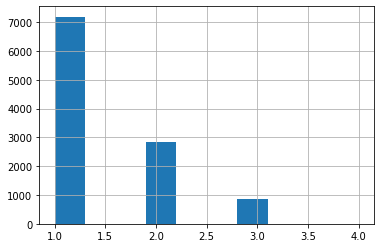

In [3]:
train['weather'].hist()

In [4]:
# feature engineering
train = train[train['weather'] != 4]
all_data = pd.concat([train, test], ignore_index = True)

all_data['datetime'] = all_data.datetime.apply(pd.to_datetime)
all_data['year'] = all_data.datetime.apply(lambda x: x.year)
all_data['month'] = all_data.datetime.apply(lambda x: x.month)
all_data['day'] = all_data.datetime.apply(lambda x: x.day)
all_data['hour'] = all_data.datetime.apply(lambda x: x.hour)

all_data = all_data.drop(['datetime','casual','registered','windspeed']
                         ,axis=1)
all_data

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,16.0,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,40.0,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,32.0,2011,1,1,2
3,1,0,0,1,9.84,14.395,75,13.0,2011,1,1,3
4,1,0,0,1,9.84,14.395,75,1.0,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,12,31,19
17374,1,0,1,2,10.66,12.880,60,NaN,2012,12,31,20
17375,1,0,1,1,10.66,12.880,60,NaN,2012,12,31,21
17376,1,0,1,1,10.66,13.635,56,NaN,2012,12,31,22


In [5]:
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]
X_test

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,month,day,hour
10885,1,0,1,1,10.66,11.365,56,NaN,2011,1,20,0
10886,1,0,1,1,10.66,13.635,56,NaN,2011,1,20,1
10887,1,0,1,1,10.66,13.635,56,NaN,2011,1,20,2
10888,1,0,1,1,10.66,12.880,56,NaN,2011,1,20,3
10889,1,0,1,1,10.66,12.880,56,NaN,2011,1,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,12,31,19
17374,1,0,1,2,10.66,12.880,60,NaN,2012,12,31,20
17375,1,0,1,1,10.66,12.880,60,NaN,2012,12,31,21
17376,1,0,1,1,10.66,13.635,56,NaN,2012,12,31,22


In [6]:
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)
y = train['count']
y

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: count, Length: 10885, dtype: int64

# 3. model

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb

model = xgb.XGBRegressor()
parameters = {
    'random_state': [42]
    ,'n_estimators': [350, 370, 390]
    ,'max_depth' : [4]
    ,'learning_rate': [0.1, 0.15]
}

reg_rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
gridsearch_model = GridSearchCV(estimator=model
                               ,param_grid=parameters
                               ,scoring=reg_rmsle_scorer
                               ,cv=5)

log_y = np.log(y)
gridsearch_model.fit(X_train, log_y)

print('최적 하이퍼파라미터: ', gridsearch_model.best_params_)


최적 하이퍼파라미터:  {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 350, 'random_state': 42}


In [21]:
predictions = gridsearch_model.best_estimator_.predict(X_test)


In [22]:
submission['count'] = np.exp(predictions)
submission.to_csv('submission.csv', index = False)